In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
train_transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
    transforms.Resize([224,224])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
    transforms.Resize([224,224])
])
# you can try other transforms, e.g. add random flip, random crop or etc to augment your data.
trainset =  torchvision.datasets.Flowers102(root='./data', split='test',
                                        download=True, transform=train_transform)
# transet is an iterable object, you can use for loop to access the data or get any data use 'trainset[<int>]'.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
                                          
valset =  torchvision.datasets.Flowers102(root='./data', split='val',
                                       download=True, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                         shuffle=False, num_workers=2)
# trainloader is an dataloader object from pytorch, you can use for loop to access the data,
# or use next(iter(trainloader)) to get a batch of data.
testset =  torchvision.datasets.Flowers102(root='./data', split='train',
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [3]:
print(f'trainset size: {len(trainset)}')
print(f'valset size: {len(valset)}')
print(f'testset size: {len(testset)}')

trainset size: 6149
valset size: 1020
testset size: 1020


In [4]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(43) tensor(38) tensor(42) tensor(41) tensor(36) tensor(9) tensor(27) tensor(50)


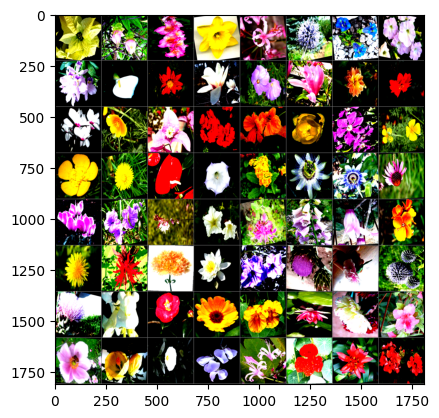

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #原先做歸一化[0,1]->[-1,1],通過這個從[-1,1]->[0,1]
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() #matplotlib是處理numpy array,所以要轉換成numpy
    # 0,1,2對應到原先img的(C,H,W)的index,
    # matplotlib需要(H,W,C),因此要將index照著(H,W,C)下去擺
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader) # 把loader轉換成iterator
images, labels = next(dataiter) # 會從iterator中選出下一個元素

# show images
imshow(torchvision.utils.make_grid(images)) # make_grid會將圖像張量拼接成一個網格,如下圖
print(' '.join('%5s' % labels[j] for j in range(8)))

In [6]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # ResNet-18 block架構為 (3x3 conv + bn + Activation function) * 2, 最後加上誤差值後, 要在一層Activation function
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) # 3*3 conv with 1*1 kernel, 這層的stride會使用參數是因為有可能會是2
        self.bn1 = nn.BatchNorm2d(out_channels) # use bn1 
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) # 3*3 conv with 1*1 kernel, 但這層固定是1 in ResNet-18
        self.bn2 = nn.BatchNorm2d(out_channels) # other bn2
        self.relu = nn.ReLU(inplace=True)
        # 這是用來降維的, 當我的in_channel != out_channel時, 我需要做降維, 但有兩種寫法, 一種是shortcut, 直接在這做, 但我想放到ResNet內做.
        # 例子是今天進ResNet後, 只會接一層conv, out_chaneel為64, stride = 2, 所以代表圖片高寬會/2, 假設圖片原始為3*224*224, 那after conv後為6*112*112
        # 那接著我如果需要把channel變成128, 我就需要將高寬先降維, 利用stride = 2來做, 所以會變成 128*56*56
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_channels = 64 # 這是做完一層conv後的in_channel, 最初進來的是3, 是圖片的RGB.

        # 此為第一階段, 7*7 conv後
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2) 
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 第一層
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 進到誤差值計算
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # 做一個平均,讓最後512*7*7可以平均成512*1*1, 再接著利用flatten轉變成1*1
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [7]:
# 初始化模型
net = ResNet18(num_classes=102).to(device)
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 6

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[40,70],gamma=0.2)

In [9]:
import torch
torch.autograd.set_detect_anomaly(True)

In [10]:
EPOCHS = 100 # you can try more epochs number to get better performance.
torch.cuda.empty_cache()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    train_loss = 0
    correct = 0
    total = 0
    net.train()
    # training step
    for i, data in enumerate(trainloader,0):
        # # get the inputs, and use .to(device) to move your data to accelerator.
        inputs, labels = data[0].to(device), data[1].to(device)
        # Eliminate previous gradients to avoid gradients accumulation.
        optimizer.zero_grad()
        
        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
    scheduler.step()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)    

    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(valloader,0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%')
    
print('\nFinished Training And Validation')

Epoch 1/100, Train Loss: 3.6216, Val Loss: 4.3579, Train Acc: 15.91%, Val Acc: 9.61%
Epoch 2/100, Train Loss: 3.0157, Val Loss: 3.5379, Train Acc: 24.62%, Val Acc: 15.98%
Epoch 3/100, Train Loss: 2.7400, Val Loss: 3.2889, Train Acc: 30.09%, Val Acc: 20.69%
Epoch 4/100, Train Loss: 2.5178, Val Loss: 3.1547, Train Acc: 34.27%, Val Acc: 25.69%
Epoch 5/100, Train Loss: 2.3215, Val Loss: 3.0829, Train Acc: 38.51%, Val Acc: 23.24%
Epoch 6/100, Train Loss: 2.1968, Val Loss: 2.7480, Train Acc: 41.11%, Val Acc: 29.41%
Epoch 7/100, Train Loss: 2.0231, Val Loss: 2.5308, Train Acc: 45.10%, Val Acc: 33.43%
Epoch 8/100, Train Loss: 1.8805, Val Loss: 2.3864, Train Acc: 49.10%, Val Acc: 37.65%
Epoch 9/100, Train Loss: 1.7958, Val Loss: 2.3963, Train Acc: 49.78%, Val Acc: 38.73%
Epoch 10/100, Train Loss: 1.6868, Val Loss: 2.3440, Train Acc: 53.03%, Val Acc: 41.76%
Epoch 11/100, Train Loss: 1.5660, Val Loss: 2.2073, Train Acc: 55.64%, Val Acc: 44.22%
Epoch 12/100, Train Loss: 1.4518, Val Loss: 2.3165, T

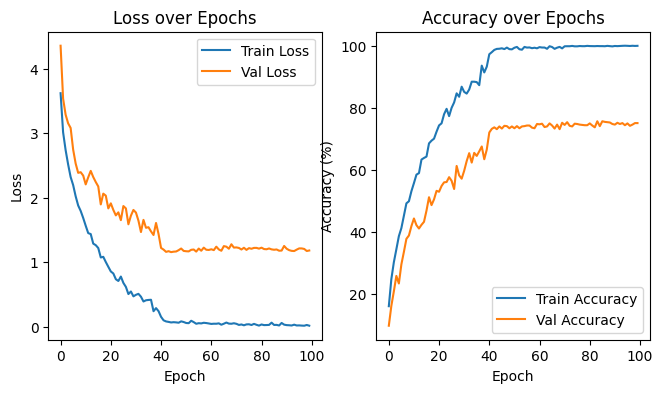

In [12]:
# 绘制训练和验证的损失曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和验证的准确率曲线
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [11]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # 由於.sum()是return tensor結構,使用item()轉成一般結構
        correct += (predicted.cpu() == labels).sum().item() # 由於labels是存在CPU, 所以要將prdicted放入cpu去比較

print('Accuracy of the network on the 1020 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1020 test images: 75 %
